### Data Consistency Checking

In [3]:
BASE_DIR = '/kaggle/input/surveillance-for-retail-stores/face_identification/face_identification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [12]:
import os
import pandas as pd

# Base directory where the data is stored
BASE_DIR = '/kaggle/input/surveillance-for-retail-stores/face_identification/face_identification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# CSV file paths
train_csv_path = os.path.join(BASE_DIR, 'trainset.csv')
eval_csv_path = os.path.join(BASE_DIR, 'eval_set.csv')

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
eval_df = pd.read_csv(eval_csv_path)

# === Checking Training Set Consistency ===
print("=== Checking Training Set Consistency ===")
# For training images, CSV paths are like "train/person_100/85.jpg"
missing_train_files = []
for idx, row in train_df.iterrows():
    csv_path = row['image_path']
    full_path = os.path.join(BASE_DIR, csv_path)
    if not os.path.exists(full_path):
        missing_train_files.append(full_path)

if missing_train_files:
    print("Missing training files (from CSV):")
    for f in missing_train_files:
        print(f"  - {f}")
else:
    print("All files listed in trainset.csv exist.")

# Check for extra files in TRAIN_DIR not in CSV
csv_train_files = set()
for path in train_df['image_path']:
    rel_path = path[len("train/"):] if path.startswith("train/") else path
    csv_train_files.add(rel_path)

actual_train_files = []
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        rel_path = os.path.relpath(os.path.join(root, file), TRAIN_DIR)
        actual_train_files.append(rel_path)

extra_train_files = set(actual_train_files) - csv_train_files

if extra_train_files:
    print("\nExtra training files in the train directory (not listed in CSV):")
    for f in extra_train_files:
        print(f"  - {f}")
else:
    print("No extra training files found; CSV matches the train directory.")

# === Checking Evaluation Set Consistency ===
print("\n=== Checking Evaluation Set Consistency ===")
# For evaluation, CSV image names (e.g., "9198.jpg") should be in TEST_DIR
missing_eval_files = []
for idx, row in eval_df.iterrows():
    image_name = row['image_path']
    full_path = os.path.join(TEST_DIR, image_name)
    if not os.path.exists(full_path):
        missing_eval_files.append(full_path)

if missing_eval_files:
    print("Missing evaluation files (from CSV):")
    for f in missing_eval_files:
        print(f"  - {f}")
else:
    print("All files listed in eval_set.csv exist in the test directory.")

# Check for extra files in TEST_DIR not in CSV
csv_eval_files = set(eval_df['image_path'].tolist())
actual_eval_files = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]
extra_eval_files = set(actual_eval_files) - csv_eval_files

if extra_eval_files:
    print("\nExtra evaluation files in the test directory (not listed in CSV):")
    for f in extra_eval_files:
        print(f"  - {f}")
else:
    print("No extra evaluation files found; CSV matches the test directory.")

# === Numerical Report ===
print("\n=== Numerical Report ===")

# Training Set Statistics
print("\n--- Training Set Statistics ---")
total_train_images = len(train_df)
print(f"Total images in CSV: {total_train_images}")

# Extract person_id (e.g., "train/person_100/85.jpg" -> "person_100")
train_df['person_id'] = train_df['image_path'].apply(lambda x: x.split('/')[1])
unique_persons_train = train_df['person_id'].nunique()
print(f"Unique persons: {unique_persons_train}")

# Distribution of images per person
images_per_person = train_df.groupby('person_id').size()
print("Images per person:")
print(f"  Min: {images_per_person.min()}")
print(f"  Max: {images_per_person.max()}")
print(f"  Mean: {images_per_person.mean():.2f}")
print(f"  Median: {images_per_person.median()}")
print(f"  Std Dev: {images_per_person.std():.2f}")

print(f"Missing files: {len(missing_train_files)}")
print(f"Extra files: {len(extra_train_files)}")

# Test Set Statistics
print("\n--- Test Set Statistics ---")
total_test_images = len(eval_df)
print(f"Total images in CSV: {total_test_images}")

if 'label' in eval_df.columns:
    unique_persons_test = eval_df['label'].nunique()
    print(f"Unique persons: {unique_persons_test}")
    train_persons = set(train_df['person_id'])
    test_persons = set(eval_df['label'])
    unseen_persons = test_persons - train_persons
    print(f"Unseen persons: {len(unseen_persons)}")
else:
    print("Unique persons: N/A (no 'label' column)")

print(f"Missing files: {len(missing_eval_files)}")
print(f"Extra files: {len(extra_eval_files)}")

# Summary
print("\n--- Summary ---")
print(f"Training images: {total_train_images} (unique persons: {unique_persons_train})")
print(f"Test images: {total_test_images}")
if 'label' in eval_df.columns:
    print(f"Test unique persons: {unique_persons_test} (unseen: {len(unseen_persons)})")
else:
    print("Test unique persons: N/A")
print(f"Total missing files: {len(missing_train_files) + len(missing_eval_files)}")
print(f"Total extra files: {len(extra_train_files) + len(extra_eval_files)}")

=== Checking Training Set Consistency ===
All files listed in trainset.csv exist.
No extra training files found; CSV matches the train directory.

=== Checking Evaluation Set Consistency ===
All files listed in eval_set.csv exist in the test directory.
No extra evaluation files found; CSV matches the test directory.

=== Numerical Report ===

**Training Set Statistics**
Total number of images listed in CSV: 6828
Number of unique persons: 125
Images per person:
  Minimum: 5
  Maximum: 283
  Mean: 54.62
  Median: 49.0
  Standard deviation: 41.37
Number of missing files (listed in CSV but not found): 0
Number of extra files (in directory but not in CSV): 0

**Test Set Statistics**
Total number of images listed in CSV: 4734
Number of missing files (listed in CSV but not found): 0
Number of extra files (in directory but not in CSV): 0


<br><br><br><br>

### Data Is Consistant, We can move forward now

In [4]:
%%capture
!pip install deepface

#### Creating Validation Set

In [8]:
import os
import random
import statistics

# Organize dataset into training and validation sets
train_files, val_files = {}, {}

print("Organizing dataset...")

person_dirs = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
for person in person_dirs:
    person_path = os.path.join(TRAIN_DIR, person)
    images = [os.path.join(person_path, f) for f in os.listdir(person_path) if os.path.isfile(os.path.join(person_path, f))]
    if not images:
        continue
    random.shuffle(images)
    split_idx = int(0.8 * len(images))
    train_files[person], val_files[person] = images[:split_idx], images[split_idx:]

# Function to generate report
def generate_report(file_dict, dataset_name):
    total_images = sum(len(images) for images in file_dict.values())
    num_persons = len(file_dict)
    person_image_counts = [len(images) for images in file_dict.values() if len(images) > 0]
    
    if person_image_counts:
        min_images = min(person_image_counts)
        max_images = max(person_image_counts)
        mean_images = total_images / num_persons
        median_images = statistics.median(person_image_counts)
    else:
        min_images = 0
        max_images = 0
        mean_images = 0
        median_images = 0
    
    print(f"\n{dataset_name} Dataset Report:")
    print(f"Total number of images: {total_images}")
    print(f"Number of unique persons: {num_persons}")
    print("Images per person:")
    print(f"  Minimum: {min_images}")
    print(f"  Maximum: {max_images}")
    print(f"  Mean: {mean_images:.2f}")
    print(f"  Median: {median_images}")

# Generate reports for training and validation sets
generate_report(train_files, "Training")
generate_report(val_files, "Validation")

Organizing dataset...

Training Dataset Report:
Total number of images: 5412
Number of unique persons: 125
Images per person:
  Minimum: 4
  Maximum: 226
  Mean: 43.30
  Median: 39

Validation Dataset Report:
Total number of images: 1416
Number of unique persons: 125
Images per person:
  Minimum: 1
  Maximum: 57
  Mean: 11.33
  Median: 10


<br><br><br><br>

### DeepFace Embedding Similarity Trial

In [ ]:
import numpy as np
import pandas as pd
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm


print("Initializing face recognition pipeline...")

# Function to compute embedding using DeepFace
def get_embedding_deepface(image_path, model_name='Facenet'):
    try:
        reps = DeepFace.represent(img_path=image_path, model_name=model_name, enforce_detection=False)
        if reps and 'embedding' in reps[0]:
            return np.array(reps[0]['embedding'])
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
    return None

random.seed(42)

print("Computing training embeddings...")
train_embeddings = {}

for person in tqdm(train_files, desc="Processing training embeddings"):
    embeddings = [get_embedding_deepface(img) for img in train_files[person] if get_embedding_deepface(img) is not None]
    if embeddings:
        train_embeddings[person] = np.mean(embeddings, axis=0)

# Predict identity using cosine similarity
def predict_person(test_emb, threshold=0.6):
    similarities = {person: cosine_similarity(test_emb.reshape(1, -1), emb.reshape(1, -1))[0][0] for person, emb in train_embeddings.items()}
    pred_person, max_sim = max(similarities.items(), key=lambda x: x[1], default=(None, -1))
    return pred_person if max_sim >= threshold else "doesn't_exist"

# Evaluate model performance
def evaluate_performance(file_dict, dataset_name):
    print(f"\nEvaluating {dataset_name} set...")
    true_labels, pred_labels = [], []
    for person in tqdm(file_dict, desc=f"Processing {dataset_name} set"):
        for img_path in file_dict[person]:
            emb = get_embedding_deepface(img_path)
            if emb is None:
                continue
            pred = predict_person(emb)
            true_labels.append(person)
            pred_labels.append(pred)
    acc = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy on {dataset_name} set: {acc:.4f}")
    print(classification_report(true_labels, pred_labels))
    return true_labels, pred_labels

print("Starting model evaluation...")
train_true, train_pred = evaluate_performance(train_files, "Training")
val_true, val_pred = evaluate_performance(val_files, "Validation")

print("Process completed successfully!")

25-02-27 22:41:01 - Directory /root/.deepface has been created
25-02-27 22:41:01 - Directory /root/.deepface/weights has been created
Initializing face recognition pipeline...
Computing training embeddings...


Processing training embeddings:   0%|          | 0/125 [00:00<?, ?it/s]

25-02-27 22:41:04 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
 12%|█▏        | 11.0M/92.2M [00:00<00:00, 89.3MB/s]
 32%|███▏      | 29.9M/92.2M [00:00<00:00, 142MB/s] 
 49%|████▉     | 45.1M/92.2M [00:00<00:00, 115MB/s]
 68%|██████▊   | 62.9M/92.2M [00:00<00:00, 135MB/s]
100%|██████████| 92.2M/92.2M [00:00<00:00, 124MB/s]
Processing training embeddings:  71%|███████   | 89/125 [33:46<20:36, 34.36s/it]  

In [56]:
print("Number Of Persons in the DB: ", len(train_embeddings.keys()))
print("Embeddings Vector Length: ", len(train_embeddings['person_0']))

Number Of Persons in the DB:  125
Embeddings Vector Length:  128


### Saving The Embeddings

In [67]:
import pandas as pd
emb = pd.DataFrame(train_embeddings)

emb.to_csv('train_embeddings.csv', index=False)


### Results Visualizations

Plots saved to person_metrics_visualization.png


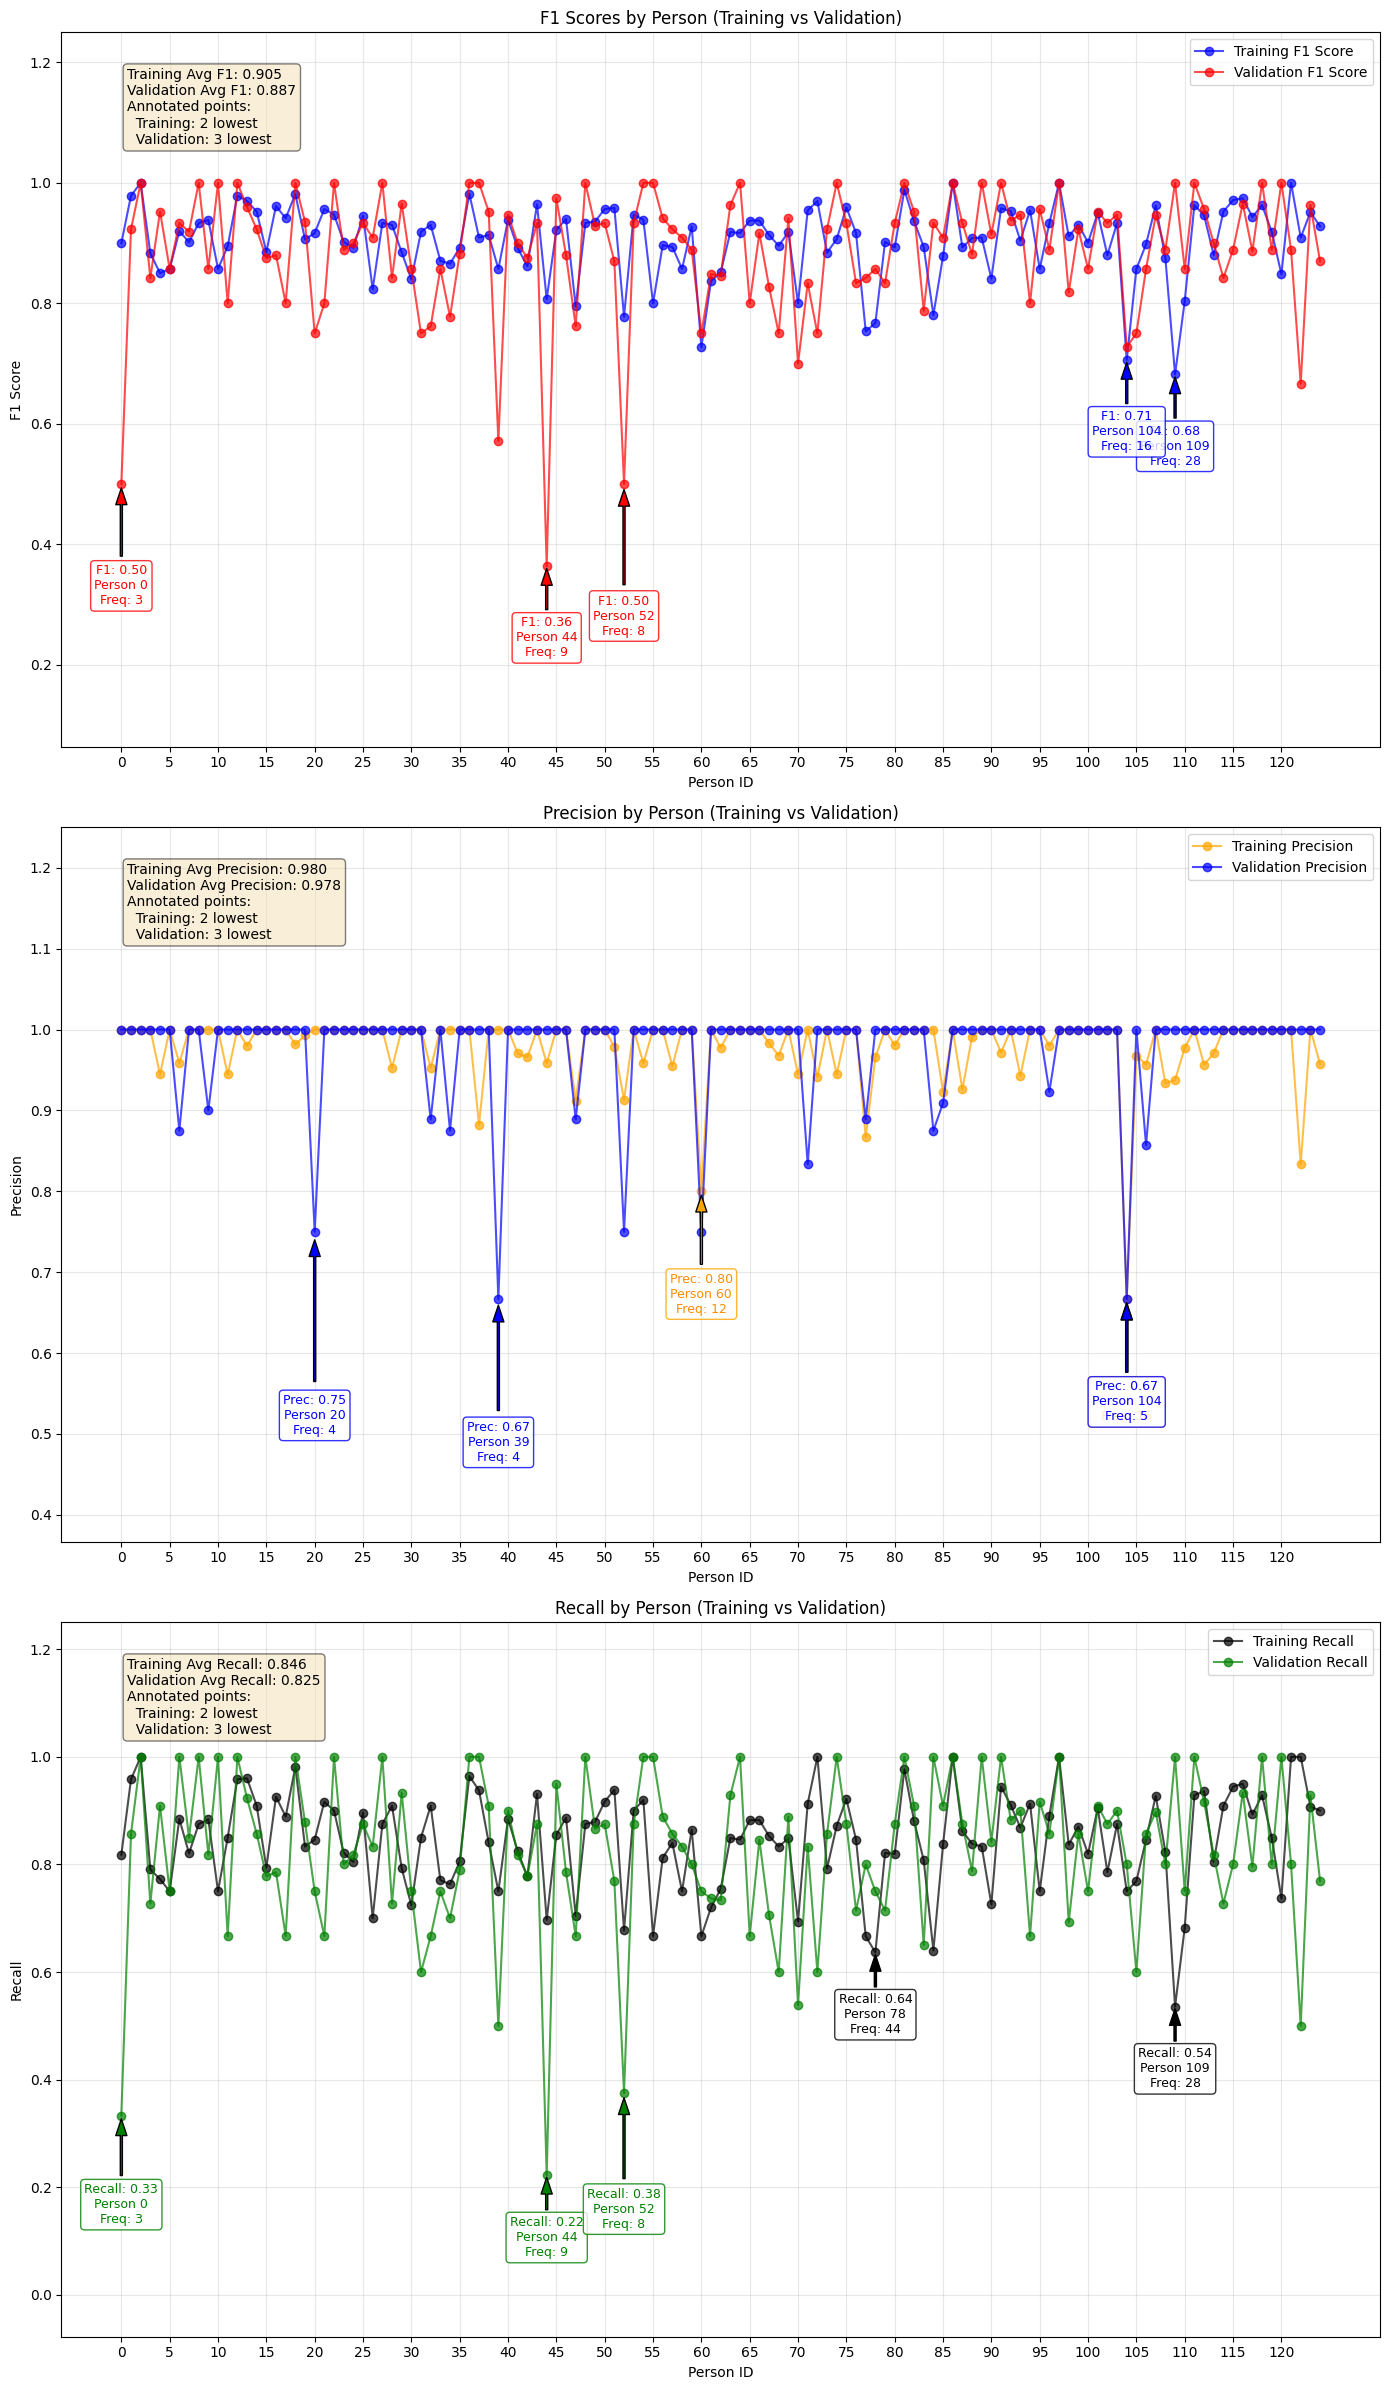

2 lowest performers in training set:
    person_id  train_frequency  train_f1
12        109               28  0.681818
7         104               16  0.705882

3 lowest performers in validation set:
    person_id  val_frequency    val_f1
64         44              9  0.363636
0           0              3  0.500000
73         52              8  0.500000


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import Counter

def generate_person_classification_summary(train_true, train_pred, val_true, val_pred):
    train_freq = Counter(train_true)
    val_freq = Counter(val_true)
    
    persons = np.unique([p for p in np.unique(np.concatenate([train_true, val_true])) 
                         if 'person' in str(p)])
    results = []
    
    for person in persons:
        y_true_train = (np.array(train_true) == person).astype(int)
        y_pred_train = (np.array(train_pred) == person).astype(int)
        
        train_precision = precision_score(y_true_train, y_pred_train, zero_division=0)
        train_recall = recall_score(y_true_train, y_pred_train, zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, zero_division=0)
        
        y_true_val = (np.array(val_true) == person).astype(int)
        y_pred_val = (np.array(val_pred) == person).astype(int)
        
        val_precision = precision_score(y_true_val, y_pred_val, zero_division=0)
        val_recall = recall_score(y_true_val, y_pred_val, zero_division=0)
        val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)
        
        person_id = int(str(person).split('_')[-1])
        
        results.append({
            'person': person,
            'person_id': person_id,
            'train_frequency': train_freq.get(person, 0),
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'val_frequency': val_freq.get(person, 0),
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        })
    
    results_df = pd.DataFrame(results).sort_values('person_id')
    
    return results_df

def plot_all_metrics_by_person(train_true, train_pred, val_true, val_pred, save_path='metrics_plots.png'):
    train_true = np.array(train_true)
    train_pred = np.array(train_pred)
    val_true = np.array(val_true)
    val_pred = np.array(val_pred)
    
    summary_df = generate_person_classification_summary(train_true, train_pred, val_true, val_pred)
    
    person_ids = summary_df['person_id'].values
    train_f1_values = summary_df['train_f1'].values
    val_f1_values = summary_df['val_f1'].values
    train_precision_values = summary_df['train_precision'].values
    val_precision_values = summary_df['val_precision'].values
    train_recall_values = summary_df['train_recall'].values
    val_recall_values = summary_df['val_recall'].values
    train_freqs = summary_df['train_frequency'].values
    val_freqs = summary_df['val_frequency'].values

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 24))
    
    # Plot 1: F1 Scores - Blue and Red (as is)
    ax1.plot(person_ids, train_f1_values, 'b-', label='Training F1 Score', marker='o', alpha=0.7)
    ax1.plot(person_ids, val_f1_values, 'r-', label='Validation F1 Score', marker='o', alpha=0.7)
    
    train_min_indices = np.argsort(train_f1_values)[:2]
    val_min_indices = np.argsort(val_f1_values)[:3]
    
    for i, idx in enumerate(train_min_indices):
        ax1.annotate(f'F1: {train_f1_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {train_freqs[idx]}',
                     xy=(person_ids[idx], train_f1_values[idx]),
                     xytext=(person_ids[idx], train_f1_values[idx] - 0.15),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='blue', ha='center', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))
    
    for i, idx in enumerate(val_min_indices):
        y_offset = -0.15 - (i * 0.05)
        ax1.annotate(f'F1: {val_f1_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {val_freqs[idx]}',
                     xy=(person_ids[idx], val_f1_values[idx]),
                     xytext=(person_ids[idx], val_f1_values[idx] + y_offset),
                     arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='red', ha='center', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
    
    ax1.set_xlabel('Person ID')
    ax1.set_ylabel('F1 Score')
    ax1.set_title('F1 Scores by Person (Training vs Validation)')
    ax1.set_xticks(person_ids[::5])
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_ylim(min(min(train_f1_values), min(val_f1_values)) - 0.3, 
                 max(max(train_f1_values), max(val_f1_values)) + 0.25)
    
    train_avg_f1 = np.mean(train_f1_values)
    val_avg_f1 = np.mean(val_f1_values)
    textstr_f1 = (f'Training Avg F1: {train_avg_f1:.3f}\n'
                  f'Validation Avg F1: {val_avg_f1:.3f}\n'
                  f'Annotated points:\n'
                  f'  Training: 2 lowest\n'
                  f'  Validation: 3 lowest')
    ax1.text(0.05, 0.95, textstr_f1, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Precision - Orange and Blue
    ax2.plot(person_ids, train_precision_values, 'C1-', marker='o', label='Training Precision', alpha=0.7, color='orange')
    ax2.plot(person_ids, val_precision_values, 'b-', marker='o', label='Validation Precision', alpha=0.7)
    
    train_min_indices = np.argsort(train_precision_values)[:2]
    val_min_indices = np.argsort(val_precision_values)[:3]
    
    for i, idx in enumerate(train_min_indices):
        ax2.annotate(f'Prec: {train_precision_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {train_freqs[idx]}',
                     xy=(person_ids[idx], train_precision_values[idx]),
                     xytext=(person_ids[idx], train_precision_values[idx] - 0.15),
                     arrowprops=dict(facecolor='orange', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='darkorange', ha='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", alpha=0.8))
    
    for i, idx in enumerate(val_min_indices):
        y_offset = -0.15 - (i * 0.05)
        ax2.annotate(f'Prec: {val_precision_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {val_freqs[idx]}',
                     xy=(person_ids[idx], val_precision_values[idx]),
                     xytext=(person_ids[idx], val_precision_values[idx] + y_offset),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='blue', ha='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))
    
    ax2.set_xlabel('Person ID')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision by Person (Training vs Validation)')
    ax2.set_xticks(person_ids[::5])
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_ylim(min(min(train_precision_values), min(val_precision_values)) - 0.3, 
                 max(max(train_precision_values), max(val_precision_values)) + 0.25)
    
    train_avg_prec = np.mean(train_precision_values)
    val_avg_prec = np.mean(val_precision_values)
    textstr_prec = (f'Training Avg Precision: {train_avg_prec:.3f}\n'
                    f'Validation Avg Precision: {val_avg_prec:.3f}\n'
                    f'Annotated points:\n'
                    f'  Training: 2 lowest\n'
                    f'  Validation: 3 lowest')
    ax2.text(0.05, 0.95, textstr_prec, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 3: Recall - Black and Green
    ax3.plot(person_ids, train_recall_values, 'k-', marker='o', label='Training Recall', alpha=0.7)
    ax3.plot(person_ids, val_recall_values, 'g-', marker='o', label='Validation Recall', alpha=0.7)
    
    train_min_indices = np.argsort(train_recall_values)[:2]
    val_min_indices = np.argsort(val_recall_values)[:3]
    
    for i, idx in enumerate(train_min_indices):
        ax3.annotate(f'Recall: {train_recall_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {train_freqs[idx]}',
                     xy=(person_ids[idx], train_recall_values[idx]),
                     xytext=(person_ids[idx], train_recall_values[idx] - 0.15),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='black', ha='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    for i, idx in enumerate(val_min_indices):
        y_offset = -0.15 - (i * 0.05)
        ax3.annotate(f'Recall: {val_recall_values[idx]:.2f}\nPerson {person_ids[idx]}\nFreq: {val_freqs[idx]}',
                     xy=(person_ids[idx], val_recall_values[idx]),
                     xytext=(person_ids[idx], val_recall_values[idx] + y_offset),
                     arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=9, color='green', ha='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
    
    ax3.set_xlabel('Person ID')
    ax3.set_ylabel('Recall')
    ax3.set_title('Recall by Person (Training vs Validation)')
    ax3.set_xticks(person_ids[::5])
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.set_ylim(min(min(train_recall_values), min(val_recall_values)) - 0.3, 
                 max(max(train_recall_values), max(val_recall_values)) + 0.25)
    
    train_avg_recall = np.mean(train_recall_values)
    val_avg_recall = np.mean(val_recall_values)
    textstr_recall = (f'Training Avg Recall: {train_avg_recall:.3f}\n'
                      f'Validation Avg Recall: {val_avg_recall:.3f}\n'
                      f'Annotated points:\n'
                      f'  Training: 2 lowest\n'
                      f'  Validation: 3 lowest')
    ax3.text(0.05, 0.95, textstr_recall, transform=ax3.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plots saved to {save_path}")
    
    return fig

fig = plot_all_metrics_by_person(train_true, train_pred, val_true, val_pred, save_path='person_metrics_visualization.png')
plt.show()

summary_df = generate_person_classification_summary(train_true, train_pred, val_true, val_pred)

train_lowest = summary_df.nsmallest(2, 'train_f1')
val_lowest = summary_df.nsmallest(3, 'val_f1')

print("2 lowest performers in training set:")
print(train_lowest[['person_id', 'train_frequency', 'train_f1']])

print("\n3 lowest performers in validation set:")
print(val_lowest[['person_id', 'val_frequency', 'val_f1']])